In [1]:
import os
import time
import json
import numpy as np
import pandas as pd
import re
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)



In [2]:
DATA_PATH = "data/emotions.csv"
df = pd.read_csv(DATA_PATH,index_col=0)

df.head()


,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [3]:
print("Before dedup:", len(df))

df = df.drop_duplicates(subset="text").reset_index(drop=True)

print("After dedup:", len(df))


Before dedup: 416809
After dedup: 393822


In [4]:
df["label"].value_counts(normalize=True)

,proportion
label,
1,0.342871
0,0.300925
3,0.139091
4,0.110784
2,0.074826
5,0.031504


In [5]:
url_pattern = re.compile(r"http\S+|www\.\S+")
mention_pattern = re.compile(r"@\w+")
space_pattern = re.compile(r"\s+")

def clean_text(s):
    s = str(s).lower()
    s = url_pattern.sub(" ", s)
    s = mention_pattern.sub(" ", s)
    s = space_pattern.sub(" ", s)
    return s.strip()

df["text"] = df["text"].apply(clean_text)

df[["text"]].head()

,text
0,i just feel really helpless and heavy hearted
1,ive enjoyed being able to slouch about relax a...
2,i gave up my internship with the dmrg and am f...
3,i dont know i feel so lost
4,i am a kindergarten teacher and i am thoroughl...


In [6]:
X = df["text"].values
y = df["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print(len(X_train), len(X_val), len(X_test))


315057 39382 39383


In [7]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
MAX_LEN = 80

def tokenize_batch(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=MAX_LEN
    )

train_encodings = tokenize_batch(X_train)
val_encodings   = tokenize_batch(X_val)
test_encodings  = tokenize_batch(X_test)


In [9]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [10]:
train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset   = EmotionDataset(val_encodings, y_val)
test_dataset  = EmotionDataset(test_encodings, y_test)


In [11]:
num_labels = 6

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    weighted_f1 = f1_score(labels, preds, average="weighted")

    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1
    }

In [15]:
ARTIFACTS_DIR="artifacts"
training_args = TrainingArguments(
    output_dir=ARTIFACTS_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_dir="./logs",
    report_to="none"
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-3012789700.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,0.063300,0.061392,0.966965,0.945633,0.966875
2,0.051600,0.058910,0.966203,0.938100,0.965295
3,0.046600,0.066067,0.966990,0.945586,0.967320


TrainOutput(global_step=59076, training_loss=0.06720498705275114, metrics={'train_runtime': 7190.7315, 'train_samples_per_second': 131.443, 'train_steps_per_second': 8.216, 'total_flos': 1.956457422218592e+16, 'train_loss': 0.06720498705275114, 'epoch': 3.0})

In [18]:
test_preds = trainer.predict(test_dataset)

y_logits = test_preds.predictions
y_pred   = np.argmax(y_logits, axis=1)


In [19]:
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

print(f"✅ Accuracy      : {accuracy:.4f}")
print(f"✅ Macro F1      : {macro_f1:.4f}")
print(f"✅ Weighted F1   : {weighted_f1:.4f}")


✅ Accuracy      : 0.9683
✅ Macro F1      : 0.9488
✅ Weighted F1   : 0.9681


In [20]:
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

report = classification_report(
    y_test,
    y_pred,
    target_names=labels,
    digits=4
)

print(report)


              precision    recall  f1-score   support

     sadness     0.9882    0.9837    0.9860     11851
         joy     0.9678    0.9876    0.9776     13503
        love     0.9658    0.8707    0.9158      2947
       anger     0.9515    0.9911    0.9709      5478
        fear     0.9926    0.8946    0.9410      4363
    surprise     0.8208    1.0000    0.9016      1241

    accuracy                         0.9683     39383
   macro avg     0.9478    0.9546    0.9488     39383
weighted avg     0.9697    0.9683    0.9681     39383



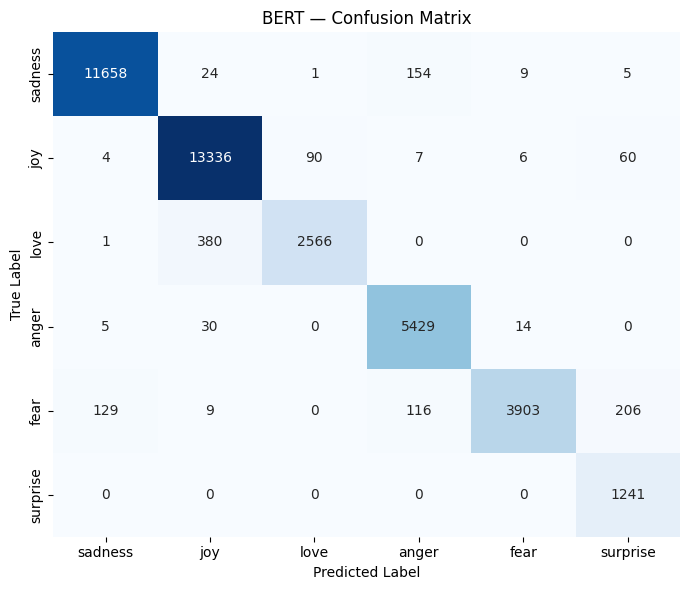

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("BERT — Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig("bert_confusion_matrix.png", dpi=150)
plt.show()


In [22]:
def bert_inference_benchmark(trainer, dataset, batch_size=32):
    start = time.time()
    _ = trainer.predict(dataset)
    end = time.time()
    return end - start

t_full = bert_inference_benchmark(trainer, test_dataset)

print(f"✅ BERT Full Test Inference Time: {t_full:.4f} sec")


✅ BERT Full Test Inference Time: 82.1860 sec


In [23]:
bert_metrics = {
    "model": MODEL_NAME,
    "accuracy": float(accuracy),
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    "inference_time_sec": {
        "full_test": float(t_full)
    },
    "num_test_samples": int(len(y_test)),
    "num_classes": 6,
    "class_labels": labels
}

with open("bert_metrics.json", "w") as json_file:
    json.dump(bert_metrics, json_file, indent=4)

print("✅ Metrics saved to bert_metrics.json")


✅ Metrics saved to bert_metrics.json
